In [129]:
import os
import re
import json
import glob
import string
import operator
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np

In [620]:
# reset matplotlib params just in case
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
import IPython.display
from IPython.display import display

In [621]:
font_params ={ 
    'size': 11.0,
    'serif': 'Times New Roman',
    'sans-serif': 'Arial',
    'family': 'sans-serif'}
plt.rc('font', **font_params)
plt.rc('figure', figsize=(8.5, 5.5), dpi=116)
plt.rc('grid', linestyle=':', color='lightgray')

In [139]:
# e.g., 'seaborn' | 'ggplot' | 'fivethirtyeight' ... see plt.style.available
#plt.style.use('ggplot')

In [140]:
print 'available styles: %s' % ' '.join(plt.style.available)

available styles: seaborn-darkgrid seaborn-notebook classic seaborn-ticks grayscale bmh seaborn-talk dark_background ggplot fivethirtyeight seaborn-colorblind seaborn-deep seaborn-whitegrid seaborn-bright seaborn-poster seaborn-muted seaborn-paper seaborn-white seaborn-pastel seaborn-dark seaborn seaborn-dark-palette


In [3]:
# mending plots
import networkx as nx
from adjustText import adjust_text

In [4]:
from wordcloud import WordCloud

# Word processing

In [5]:
def select(d, whitelist):
    '''
    Construct a dict from a subset of `d`, limited to keys that are in `whitelist`
    '''
    return {k: v for k, v in d.items() if k in whitelist}

In [6]:
def readlines_set(filepath):
    return set(line.strip() for line in open(filepath))

stopwords = {
    'postgresql': readlines_set('stopwords/postgresql-english.txt'),
    'nltk': readlines_set('stopwords/nltk-english.txt'),
    'google_1t': readlines_set('stopwords/google-1t.txt'),
    'alphabet': set(string.ascii_lowercase),
    'contraction_suffixes': {'s', 'm', 're', 've', 'll', 'd', 't'},
    'contraction_prefixes': {'don', 'isn'},
}
standard_stopwords_keys = ['google_1t', 'contraction_suffixes', 'contraction_prefixes']
standard_stopwords = set(stopword for key in standard_stopwords_keys for stopword in stopwords[key])
print '|standard_stopwords| =', len(standard_stopwords)

|standard_stopwords| = 206


In [7]:
non_linguistic = ['applause', 'cheers and applause', 'laughter', 
                  'booing', 'boos', 'crosstalk', 'inaudible', 'silence']

In [8]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # normalize numbers to avoid 000 turning up as a significant token
    s = re.sub(r',(\d{3})\b', r'\1', s)
    # leave out non-linguistic content
    s = re.sub(r'\[(' + '|'.join(non_linguistic) + r')\]', ' ', s, flags=re.I)
    # "justice" gets special treatment
    s = re.sub(r'Chief Justice', ' ', s)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [9]:
def iter_speeches_tokens(speeches, stopwords=None):
    '''
    iterate over all tokens in all the given speeches,
    each of which are a dict(text=u"Dear people, ...")
    '''
    for speech in speeches:
        for token in tokenize(speech['text'], stopwords):
            yield token

def speeches_to_counts(speeches, stopwords=None):
    return Counter(iter_speeches_tokens(speeches, stopwords))

In [10]:
def iter_group_counts(groups, vocab, smoothing=0):
    '''
    groups: a list of (group_name, group_counts) pairs
    vocab: a set/list of tokens
    '''
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [11]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [12]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [13]:
def google_1t_frequencies(tokens):
    '''
    Assuming tokens are lower-case.
    '''
    remaining_tokens = set(tokens)
    google_1t_filepath_lower = os.path.expanduser(
        '~/corpora-public/Google-1T-unigrams-only/derivatives/vocab_cs_lower')
    with open(google_1t_filepath_lower) as fp:
        for line in fp:
            token, count_string = line.decode('utf-8').split('\t')
            if token in remaining_tokens:
                remaining_tokens.remove(token)
                yield token, float(count_string) / 1024908267229.0
            if len(remaining_tokens) == 0:
                # exit as soon as we're done
                break

## Speech loading

In [14]:
all_tapp_inaugurals = [json.loads(line) for line in read_lines(['../data/tapp/inaugurals.json'])]

In [15]:
all_tapp_election2016 = [json.loads(line) for line in read_lines(['../data/tapp/election2016.json'])]

In [16]:
df_tapp_election2016 = pd.DataFrame([select(speech, {'author', 'category', 'title', 'timestamp'}) 
                                     for speech in all_tapp_election2016])

In [17]:
df_tapp_election2016.groupby(['category']).agg(dict(title=len)).reset_index()

,category,title
0,campaign speeches,383
1,press releases,6279
2,statements,834


In [18]:
df_tapp_election2016.groupby(['author']).agg(dict(title=len)).reset_index()

,author,title
0,Ben Carson,122
1,Bernie Sanders,694
2,Bobby Jindal,116
3,Carly Fiorina,1
4,Chris Christie,124
5,Donald J. Trump,340
6,George Pataki,51
7,Hillary Clinton,2504
8,Jeb Bush,314
9,Jim Webb,65


In [19]:
df_tapp_election2016.groupby(['author', 'category']).agg(dict(title=len)).reset_index(1)

,category,title
author,,
Ben Carson,campaign speeches,2
Ben Carson,press releases,110
Ben Carson,statements,10
Bernie Sanders,campaign speeches,27
Bernie Sanders,press releases,574
Bernie Sanders,statements,93
Bobby Jindal,campaign speeches,1
Bobby Jindal,press releases,93
Bobby Jindal,statements,22


In [20]:
speeches = {
    'inaugurals': all_tapp_inaugurals,
    'inaugurals_pretrump': [
        speech for speech in all_tapp_inaugurals 
        if 'Trump' not in speech['author']],
    'inaugurals_prewar': [
        speech for speech in all_tapp_inaugurals
        if speech['timestamp'] < '1948-11-01'],
    'inaugurals_postwar_pretrump': [
        speech for speech in all_tapp_inaugurals
        if speech['timestamp'] > '1948-11-01' and 'Trump' not in speech['author']],
    'trump_inaugurals': [
        speech for speech in all_tapp_inaugurals if 'Trump' in speech['author']],
    # tapp election2016 campaign 
    'election2016': all_tapp_election2016,
    'trump_election2016': [
        speech for speech in all_tapp_election2016
        if speech['author'] == 'Donald J. Trump' and speech['category'] == 'campaign speeches'],
}
for key in speeches:
    print '|speeches[{:}]| = {:d}'.format(key, len(speeches[key]))

|speeches[trump_election2016]| = 60
|speeches[inaugurals_prewar]| = 40
|speeches[inaugurals_postwar_pretrump]| = 17
|speeches[trump_inaugurals]| = 1
|speeches[inaugurals]| = 58
|speeches[inaugurals_pretrump]| = 57
|speeches[election2016]| = 7496


In [21]:
print 'using standard_stopwords'
speeches_counts = {key: speeches_to_counts(speeches[key], standard_stopwords) for key in speeches}
for key in speeches_counts:
    print '|speeches_counts[{:}]| = {:d}'.format(key, sum(speeches_counts[key].values()))

using standard_stopwords
|speeches_counts[trump_election2016]| = 72458
|speeches_counts[inaugurals_prewar]| = 43441
|speeches_counts[inaugurals_postwar_pretrump]| = 14588
|speeches_counts[trump_inaugurals]| = 622
|speeches_counts[inaugurals]| = 58651
|speeches_counts[inaugurals_pretrump]| = 58029
|speeches_counts[election2016]| = 2029798


# Proportion of speech allocated to specific word groups

In [29]:
base_synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    ('libert(y/ies)', ['liberty', 'liberties']),
    ('rights', ['rights']), 
    ('public', ['public']), 
    #('right(s)', ['right', 'rights']),
    ('justice', ['justice']),
    ('peace(ful)', ['peace', 'peaceful']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
    ('constitution', ['constitution']),
    ('russia/ussr', ['russia', 'ussr']),
    ('china', ['china']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
    #('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('great(er/est)', ['great', 'greater', 'greatest']),
    #('trump', ['trump']),
    #('donald', ['donald']),
]
base_synsets_lookup = dict(base_synsets)
def combine_synsets(*keys):
    return '+'.join(keys), [token for key in keys for token in base_synsets_lookup[key]]
synsets = base_synsets + [
    combine_synsets('freedom(s)', 'libert(y/ies)'),
    combine_synsets('freedom(s)', 'libert(y/ies)', 'rights', 'public'),
    ('china-et-al', ["china", "mexico", "military", "hell", 
                     "iran", "tough", "disaster" "horrible", 
                     "worst", "strong", "isis", "immigration", "border", "borders"]),
    #combine_synsets(['trump', 'donald']),
]

In [30]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [31]:
def iter_usages():
    sources = [('All prior inaugural addresses', speeches_counts['inaugurals_pretrump']),
               #('Pre-war inaugural addresses', speeches_counts['inaugurals_prewar']),
               #('Post-war, pre-Trump inaugural addresses', speeches_counts['inaugurals_postwar_pretrump']),
               ('Trump campaign speeches', speeches_counts['trump_election2016']),
               ('Trump inaugural address', speeches_counts['trump_inaugurals'])
    ]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [23]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [24]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t = df_usages_t.reindex([name for name, _ in synsets])
df_usages_t

source,All prior inaugural addresses,Trump campaign speeches,Trump inaugural address
synset,,,
freedom(s),0.003291,0.000290,0.001608
peace(ful),0.004842,0.000772,0.001608
justice,0.002137,0.000910,0.000000
libert(y/ies),0.002326,0.000179,0.000000
rights,0.002378,0.000331,0.000000


In [25]:
# 1/df_usages_t

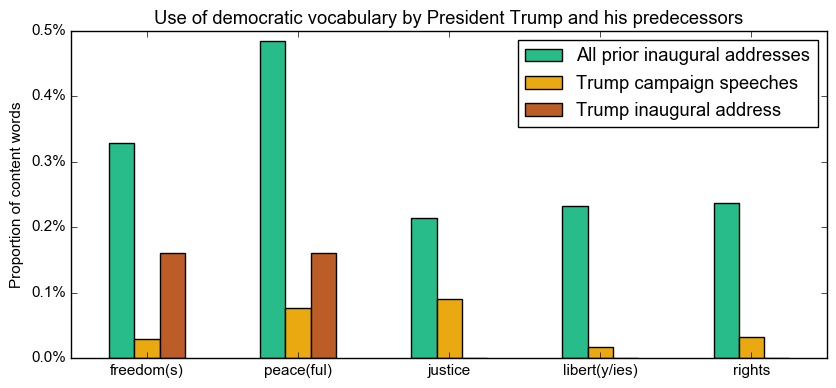

In [26]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar', color=['#27BC8A', '#EBA911', '#BC5D27'])
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y)))
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.ylabel('Proportion of content words')
plt.title('Use of democratic vocabulary by President Trump and his predecessors')
plt.tight_layout()
plt.savefig('democratic_vocabulary_proportions.pdf')

# Inaugural address word count

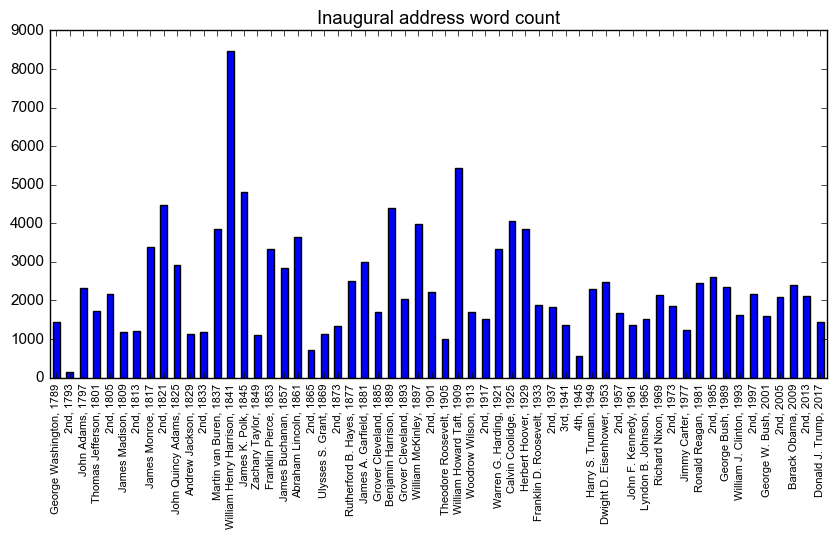

In [29]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
keep_keys = ['title', 'author', 'timestamp']
df = pd.DataFrame.from_dict(dict({key: speech[key] for key in keep_keys}.items() + 
                                 [('word_count', len(list(tokenize(speech['text']))))])
                             for speech in speeches['inaugurals'])
df['timestamp'] = pd.to_datetime(df.timestamp)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address total word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speeches

In [32]:
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7

In [33]:
def iter_surnames(speeches, surnames):
    for speech in speeches:
        text = speech['text']
        title = speech['author'] + ': ' + speech['title']
        for surname in surnames:
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [34]:
surnames_list = [speech['author'].split()[-1] for speech in speeches['inaugurals']]
surnames = set(surnames_list)

In [35]:
titles_ordered = [speech['author'] + ': ' + speech['title'] for speech in speeches['inaugurals']]
surnames_ordered = sorted(list(surnames), key=surnames_list.index)

In [37]:
df_surnames = pd.DataFrame.from_dict(iter_surnames(speeches['inaugurals'], surnames))
df_surnames

,count,surname,title
0,0,Wilson,George Washington: Inaugural Address
1,0,Jackson,George Washington: Inaugural Address
2,0,Buren,George Washington: Inaugural Address
...,...,...,...
2027,0,Truman,Donald J. Trump: Inaugural Address
2028,0,Polk,Donald J. Trump: Inaugural Address
2029,0,Monroe,Donald J. Trump: Inaugural Address


In [38]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# reorder columns
df_xtab = df_xtab[surnames_ordered]
# reorder rows
df_xtab = df_xtab.reindex(titles_ordered)
df_xtab

surname,Washington,Adams,Jefferson,...,Clinton,Obama,Trump
title,,,,,,,
George Washington: Inaugural Address,0,0,0,...,0,0,0
George Washington: Second Inaugural Address,0,0,0,...,0,0,0
John Adams: Inaugural Address,0,0,0,...,0,0,0
...,...,...,...,...,...,...,...
Barack Obama: Inaugural Address,0,0,0,...,0,0,0
Barack Obama: Second Inaugural Address,0,0,0,...,0,0,0
Donald J. Trump: Inaugural Address,2,0,0,...,1,3,0


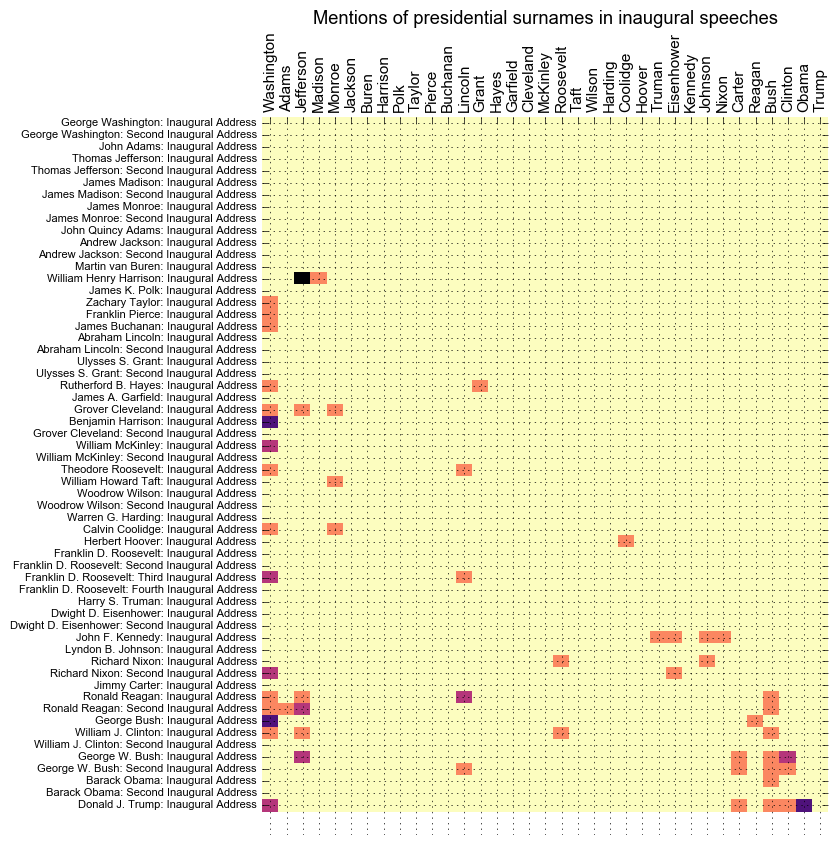

In [39]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speeches', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Self mentions in speeches

In [679]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

In [680]:
def iter_author_texts(speeches):
    for speech in speeches:
        yield speech['author'], speech['text']

In [681]:
def iter_author_text(speeches):
    keyfunc = lambda (author, text): author
    for author, author_texts in itertools.groupby(sorted(iter_author_texts(speeches), key=keyfunc), keyfunc):
        yield author, '\n\n'.join(text for author, text in author_texts)

In [682]:
candidates_speeches = [speech for speech in all_tapp_election2016
                       if speech['category'] == 'campaign speeches']

In [683]:
candidates_text = list(iter_author_text(candidates_speeches))

In [684]:
candidate_fullnames = [fullname for fullname, text in candidates_text]

In [685]:
print 'Candidates:', ', '.join(candidate_fullnames)

Candidates: Ben Carson, Bernie Sanders, Bobby Jindal, Carly Fiorina, Chris Christie, Donald J. Trump, George Pataki, Hillary Clinton, Jeb Bush, Jim Webb, John Kasich, Lincoln Chafee, Lindsey Graham, Marco Rubio, Martin O'Malley, Mike Huckabee, Rand Paul, Rick Perry, Rick Santorum, Scott Walker, Ted Cruz


In [691]:
def create_candidate_regex(fullname):
    '''
    For a fullname like 'Hillary Clinton', matches substrings like:
    
        Hillary Clinton
        Hillary R. Clinton
        Hillary Rodham Clinton (and Hillary Almost Clinton)
        Clinton
        Hillary
        
    The longer matches come first so that overlapping matches are avoided.
    '''
    parts = fullname.split()
    format_args = dict(firstname=parts[0], lastname=parts[-1])
    patterns = [
        r'{firstname} {lastname}',
        r'{firstname} [A-Z](?:\.|\w+) {lastname}',
        r'{lastname}',
        r'{firstname}',
    ]
    return re.compile('(' + '|'.join(pattern.format(**format_args) for pattern in patterns) + ')')

In [695]:
# testing...
text = (
    "It is time for Hillary Clinton to be held accountable. "
    "(44% Clinton and 42% Cruz) who will look into Hillary Clinton's email scandal. "
    "that's what it takes to dispatch both Trump and Clinton... "
    "Hillary believes that anyone who "
    "DonaldTrump against Hillary Clinton,")
clinton_re = create_candidate_regex('Hillary Clinton')
assert sum(1 for _ in clinton_re.finditer(text)) == 6, 'Found the wrong number of matches'

In [696]:
candidates_regexes = [(fullname, create_candidate_regex(fullname)) for fullname in candidate_fullnames]

In [697]:
def iter_candidates_counts():
    '''
    For each combination of candidates (including themselves), count how many mentions are in 
    '''
    for speaker_candidate, speaker_candidate_text in candidates_text:
        for target_candidate, target_candidate_re in candidates_regexes:
            for _ in target_candidate_re.finditer(speaker_candidate_text):
                yield dict(speaker=speaker_candidate, target=target_candidate)

In [698]:
df = pd.DataFrame(iter_candidates_counts())

In [700]:
df_mentions = df.groupby(['speaker', 'target']).size().to_frame('mentions')
df_mentions['log_mentions'] = np.log(df_mentions.mentions)

In [701]:
df_mentions

mentions  log_mentions
speaker        target                                 
Ben Carson     Ben Carson              5      1.609438
               Chris Christie          2      0.693147
               Donald J. Trump         3      1.098612
               Hillary Clinton         3      1.098612
Bernie Sanders Ben Carson              3      1.098612
...                                  ...           ...
Ted Cruz       Jim Webb                4      1.386294
               John Kasich             4      1.386294
               Lincoln Chafee          2      0.693147
               Lindsey Graham          1      0.000000
               Ted Cruz                9      2.197225

[187 rows x 2 columns]

In [702]:
df_xtab = df_mentions.reset_index().pivot(index='speaker', columns='target', values='log_mentions').fillna(0.0)
df_xtab

target,Ben Carson,Bernie Sanders,Bobby Jindal,Carly Fiorina,Chris Christie,...,Rand Paul,Rick Perry,Rick Santorum,Scott Walker,Ted Cruz
speaker,,,,,,,,,,,
Ben Carson,1.609438,0.000000,0.000000,0.000000,0.693147,...,0.000000,0.000000,0.000000,0.0,0.000000
Bernie Sanders,1.098612,4.859812,0.000000,0.000000,0.693147,...,1.609438,0.000000,0.000000,0.0,0.693147
Bobby Jindal,0.000000,0.000000,0.000000,0.000000,0.693147,...,0.000000,0.000000,0.000000,0.0,0.000000
Carly Fiorina,0.000000,0.000000,0.000000,0.693147,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000
Chris Christie,0.000000,0.000000,0.000000,0.000000,2.639057,...,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
Rand Paul,0.000000,0.000000,0.000000,0.000000,1.386294,...,1.791759,0.000000,0.000000,0.0,0.000000
Rick Perry,0.000000,0.000000,0.693147,0.000000,2.197225,...,0.000000,1.098612,0.000000,0.0,0.693147
Rick Santorum,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.386294,3.135494,3.332205,0.0,1.386294


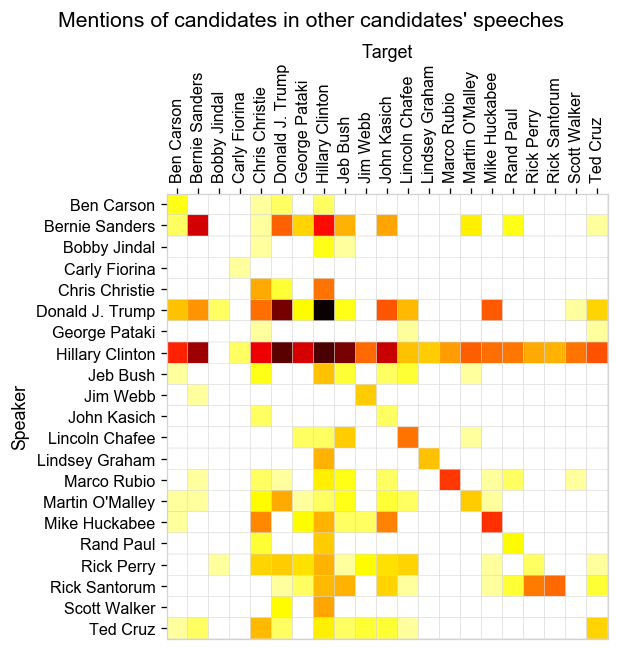

In [703]:
fig = plt.figure(figsize=(5.5,5.5))
gridcolor = 'lightgray'
# norm=mcolors.LogNorm(vmin=0, vmax=df_mentions.mentions.max()), 
plt.pcolor(df_xtab, cmap=plt.cm.hot_r, edgecolors=gridcolor)
ax = plt.axes()
# ax.set_frame_on(False)
for spine in ax.spines.values():
    spine.set_edgecolor(gridcolor)
# set up x-axis (speaker)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False, size=10)
ax.set_ylabel(df_xtab.index.name.title())
# set up y-axis (target)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(df_xtab.columns, minor=False, size=10, rotation=90)
ax.set_xlabel(df_xtab.columns.name.title())
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
# set overall titles
plt.suptitle("Mentions of candidates in other candidates' speeches", y=1.02)
plt.tight_layout()

# Trump over time

In [704]:
pd.options.display.max_rows = 20

In [705]:
def iter_speech_counts(speech, synsets):
    timestamp = pd.to_datetime(speech['timestamp'])
    counts = Counter(tokenize(speech['text'], standard_stopwords))
    total_counts = sum(counts.values())
    for synset_name, synset_tokens in synsets:
        synset_count = sum(counts.get(synset_token, 0) for synset_token in synset_tokens)
        yield dict(timestamp=timestamp, 
                   document_length=total_counts, 
                   synset=synset_name,
                   synset_count=synset_count)

In [706]:
def iter_speeches_counts(speeches, synsets):
    for i, speech in enumerate(speeches):
        for speech_count in iter_speech_counts(speech, synsets):
            yield dict(id=i, **speech_count)

In [707]:
def create_synset_df(speeches, synsets, smoothing_window=5):
    df = pd.DataFrame(iter_speeches_counts(speeches, synsets)).sort_values('timestamp').set_index(['synset', 'id'], verify_integrity=True)
    df['synset_proportion'] = df.synset_count / df.document_length
    df['synset_proportion_smoothed'] = df.groupby(level='synset', group_keys=False).apply(
        lambda g: g.synset_proportion.rolling(smoothing_window, min_periods=1, center=True).mean()
    )
    return df

In [708]:
def plot_timeseries(df, values='synset_proportion_smoothed', columns='synset', ax=None):
    df_pivot = df.reset_index().pivot_table(values=values, index='timestamp', columns=columns)
    ax = df_pivot.plot(kind='line', ax=ax, grid=True)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.02%}'.format(y)))
    ax.legend(loc='best').set_title(None)
    #ax.set_xlabel('Speech date')
    ax.set_ylabel('Percentage of content words')
    return df_pivot

In [709]:
focus_synset_names = {
    'freedom(s)', 'libert(y/ies)', 'rights', 'public',
    #'america(n(s))', 'job(s)',
}
focus_synsets = [(synset_name, synset_tokens) for synset_name, synset_tokens in synsets
                 if synset_name in focus_synset_names]

In [710]:
smoothing_window = 10
df = create_synset_df(speeches['trump_election2016'], focus_synsets, smoothing_window)

In [711]:
daily_speeches = df.reset_index().drop_duplicates(['id']).groupby('timestamp').size()
# daily_speeches

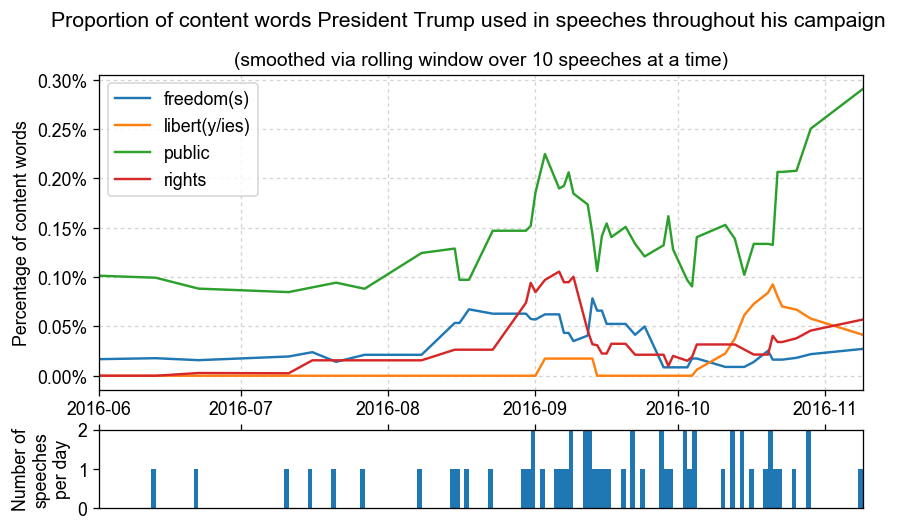

In [712]:
fig = plt.figure()#figsize=(12,5))
grid = mgridspec.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])

# produce top synsets plot
synset_ax = fig.add_subplot(grid[0])
synset_ax.tick_params(labelbottom='off')
synset_ax.xaxis.label.set_visible(False)
plot_timeseries(df, ax=synset_ax)
synset_ax.set_title('(smoothed via rolling window over %d speeches at a time)' % smoothing_window, {'fontsize': 12})

# produce bottom daily speeches plot
daily_ax = fig.add_subplot(grid[1])
daily_ax.xaxis.tick_top()
# for a bar plot, width=-1, align='edge' is like width=1, align='right' except 'right' isn't a valid align value
daily_ax.bar(timestamp_counts.index, timestamp_counts.values, width=-1, align='edge') # width is in days?
daily_ax.set_ylabel('Number of\nspeeches\nper day')

# trim axes the same
min_x = pd.to_datetime('2016-06-01')
max_x = pd.to_datetime('2016-11-09')
synset_ax.set_xlim(min_x, max_x)
daily_ax.set_xlim(min_x, max_x)
daily_ax.set_ylim(None, 2)

plt.suptitle('Proportion of content words President Trump used in speeches throughout his campaign')
# fig.tight_layout()

# Significant others

In [40]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [41]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [43]:
groups = [
    ('inaugural', speeches_counts['inaugurals_pretrump']),
    ('trump', speeches_counts['trump_inaugurals']),
]
for group_name, group_counts in groups:
    print '|{:}_counts| = {:d}'.format(group_name, sum(group_counts.values()))

|inaugural_counts| = 58029
|trump_counts| = 622


In [44]:
full_vocab = set([token for _, counts in groups for token in counts.keys()])
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 8975


In [45]:
k = 500
smoothing = 1.0

In [48]:
df_counts = pd.DataFrame.from_dict(iter_group_counts(groups, full_vocab, smoothing)).\
    groupby('group').apply(set_proportion)
# df_counts[df_counts.proportion > 0.0005]
# df_counts

In [49]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': np.mean})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [50]:
vocab = set(df_proportions_merged.nlargest(k, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 500


In [51]:
# print ' '.join(vocab)

In [999]:
# could take a second depending on how rare the vocab is
# vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [54]:
# recount with condensed vocab
# df_counts = pd.DataFrame.from_dict(iter_group_counts(groups, vocab, smoothing)).\
#     groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

In [55]:
# trump_counts = df_counts[df_counts.group=='trump']
# trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# trump_counts_reordered = trump_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# trump_counts_reordered[trump_counts_reordered.word=='donald']

In [56]:
# inaugural_counts = df_counts[df_counts.group=='inaugural']
# inaugural_counts = inaugural_counts.sort_values('proportion', ascending=False).reset_index(drop=True)
# pd.options.display.max_rows = 100
# inaugural_counts

### Oh boy word clouds

In [59]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

In [61]:
# for group, group_df in df_counts.groupby('group'):
#     plt.figure(figsize=(8.5, 4))
#     display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
#     plt.title(group)

### Back to business

That's nice to look at, but we also want some consistent ordering of relative inaugural-ness vs. Trumpery.

We can get that just by dividing one over the other. We'll use Trump proportion / Inaugural proportion, so higher values will indicate higher Trumpery.

In [62]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural

The ratio produces the desired ordering, but it ranges from very tiny values,
to 1 (meaning similar usage), to arbitrarily large values.

As we'll seen in a second with the (log-log) scatter plot, what we want is a sort of radial / angular measure.
The words around the y=x diagonal see similar usage, with the words in the upper-left being more Trump-ish and the words in the lower-right being more Inaugural.
Yay trigonometry!

In [63]:
#rad = np.arctan(df_proportions['trump/inaugural'])
rad = np.arctan2(df_proportions.trump, df_proportions.inaugural)
# re-map from [0, pi/2] to [-1, 1]
df_proportions[u'trump°inaugural'] = rad * (4.0 / np.pi) + -1.0

In [64]:
df_proportions = df_proportions.sort_values(u'trump°inaugural')

In [65]:
# df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies.get(k, 1))

In [67]:
# plt.figure(figsize=(8.5, 8.5))
# x = df_proportions['inaugural']
# plt.xscale('log')
# # plt.xlabel('global frequency of word (based on Google 1T unigrams)')
# plt.xlabel('inaugural-ness')
# y = df_proportions['trump']
# plt.yscale('log')
# # plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
# plt.ylabel('trumpery')
# # points
# plt.scatter(x, y, c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50)
# annotations = []
# for label, x, y in zip(df_proportions.index, x, y):
#     annotation = plt.annotate(label, xy=(x, y), xytext=(2, 2),
#                  size='large',
#                  textcoords='offset points', ha='left', va='bottom')
#     annotations.append(annotation)
# adjust_text(annotations, force_text=0.08, arrowprops=dict(arrowstyle="-|>", color='k', alpha=0.33))    
# plt.tight_layout()

That's neat, but kind of a mess. More directly, we can look at the actual ranking.

In [69]:
pd.options.display.max_rows = 10
df_proportions

group,inaugural,trump,trump/inaugural,trump°inaugural
word,,,,
peace,0.009134,0.001181,0.129257,-0.836333
constitution,0.007493,0.001181,0.157570,-0.801012
freedom,0.006815,0.001181,0.173245,-0.781586
union,0.006743,0.001181,0.175078,-0.779320
war,0.006387,0.001181,0.184859,-0.767258
...,...,...,...,...
dreams,0.000535,0.007084,13.235891,0.903986
factories,0.000250,0.004723,18.908416,0.932725
borders,0.000250,0.004723,18.908416,0.932725


Still, it's a lot of numbers. Let's discretize.

### Categories of trumpiness 

Having an ordering on the words means we can bin the words in discrete chunks.

The `trump/inaugural` ratio is monotonic with the `trump°inaugural` column, but since the latter has a nicer scale, we'll use it.

In [70]:
# equal bin widths:
# _, binedges = np.histogram(df_proportions[u'trump°inaugural'], bins=7)
# equal bin depths:
binedges = np.percentile(df_proportions[u'trump°inaugural'], np.linspace(0, 100, 8))

In [71]:
binnames = ['Most presidential', '2nd-most presidential', '3rd-most presidential',
            'Neutral', 
            '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy']
assignments = np.digitize(df_proportions[u'trump°inaugural'], binedges[:-1]) - 1
df_proportions['trumpiness'] = np.array(binnames)[assignments]

In [72]:
trumpiness_bins = [(name, pd.Series(list(group_df.sort_values(u'trump°inaugural', ascending=True).word)))
                   for name, group_df in df_proportions.reset_index().groupby('trumpiness')]
df_bins = pd.DataFrame(dict(trumpiness_bins)).fillna('')
df_bins = df_bins[binnames]

In [73]:
pd.options.display.max_rows = 40
# df_bins

# Focus

How about we focus in on a couple specific words.

In [76]:
# pd.options.display.max_rows = 200
# df_proportions.sort_values(u'trump°inaugural')

In [77]:
df_proportions_sorted = df_proportions.sort_values(u'trump°inaugural')

In [78]:
extremes_k = 20
pd.options.display.max_rows = extremes_k * 2
df_proportions_sorted

group,inaugural,trump,trump/inaugural,trump°inaugural,trumpiness
word,,,,,
peace,0.009134,0.001181,0.129257,-0.836333,Most presidential
constitution,0.007493,0.001181,0.157570,-0.801012,Most presidential
freedom,0.006815,0.001181,0.173245,-0.781586,Most presidential
union,0.006743,0.001181,0.175078,-0.779320,Most presidential
war,0.006387,0.001181,0.184859,-0.767258,Most presidential
government,0.021515,0.004723,0.219501,-0.724886,Most presidential
rights,0.004960,0.001181,0.238056,-0.702437,Most presidential
laws,0.004745,0.001181,0.248795,-0.689528,Most presidential
congress,0.004674,0.001181,0.252593,-0.684978,Most presidential


In [79]:
ranked_words = list(df_proportions.sort_values(u'trump°inaugural').index)
extremes = {
    'inaugural': ranked_words[:extremes_k],
    'trump': ranked_words[-extremes_k:],
}

In [84]:
extremes_vocab = set(reduce(lambda a, b: a + b, extremes.values()))

In [89]:
keywords_vocab = {'freedom', 'freedoms', 'liberty', 'liberties', 'rights', 'justice',
                  'borders', 'protected', 'jobs', 'families', 'factories', 'wealth'}

In [90]:
# df_proportions_subset = df_proportions[df_proportions.index.isin(extreme_40)]
df_proportions_subset = df_proportions

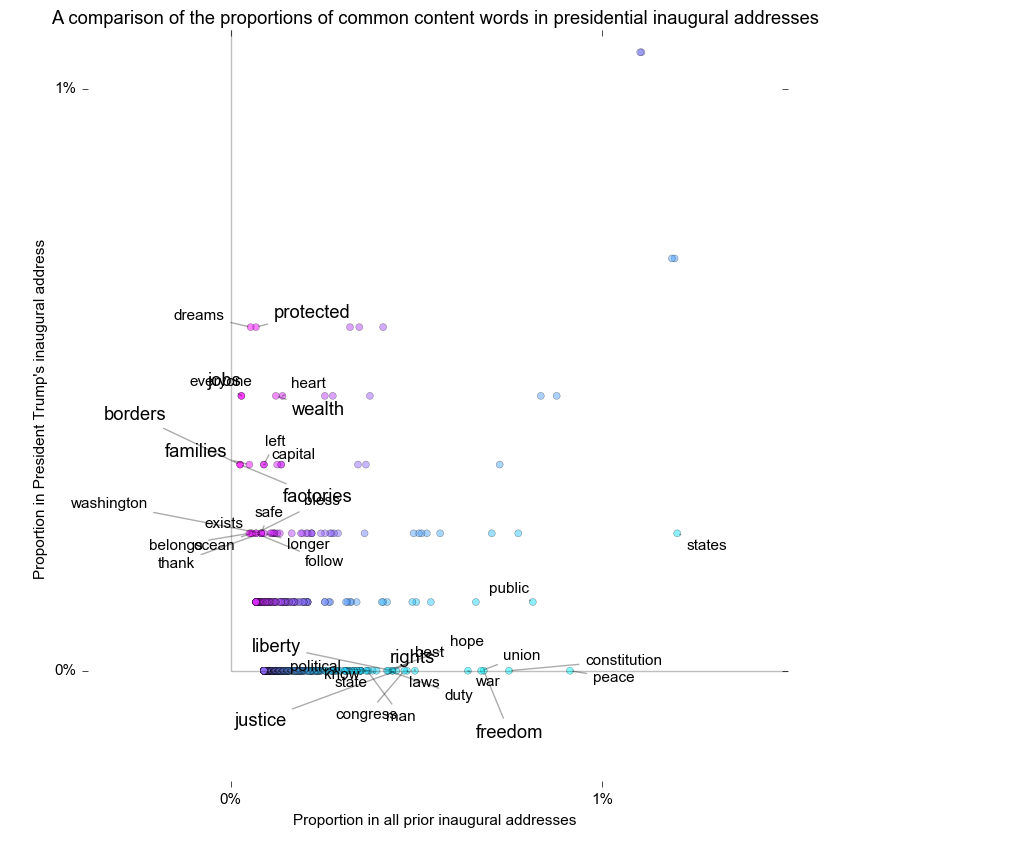

In [177]:
plt.figure(figsize=(8.5, 8.5))
xs = df_proportions_subset.inaugural
plt.xlabel("Proportion in all prior inaugural addresses")
ys = df_proportions_subset.trump - min(df_proportions_subset.trump)
plt.ylabel("Proportion in President Trump's inaugural address")
# points
plt.scatter(xs, ys, 
            c=df_proportions_subset[u'trump°inaugural'], cmap=plt.cm.cool, #c='#27BC8A',
            linewidths=.3, s=25, alpha=0.5)
ax = plt.gca()
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
# labels
annotations = []
for index, (label, x, y) in enumerate(zip(df_proportions_subset.index, xs, ys)):
    if label in extremes_vocab:
        size = 'large' if label in keywords_vocab else None
        annotation = plt.text(x, y, label, size=size)
        #annotation = plt.annotate(label, xy=(x, y), size=size)
        #, xytext=(2, 2), textcoords='offset points', ha='left', va='bottom')
        annotations.append(annotation)
# adjustments
adjust_text(annotations, force_text=0.012, force_points=0.4,
            arrowprops=dict(arrowstyle="-", color='k', alpha=0.33), lim=1000)
# plt.xlim(-2.0*margin, 0.015)
# plt.ylim(-2.0*margin, 0.015)
#plt.plot([0, plt.xlim()[1]], [0, plt.ylim()[1]])
# plt.xlim(-2.0*margin, max(xs) + 0.0017)
# plt.ylim(-.5*margin, 0.0075)
plt.vlines(0, 0, 1, alpha=0.25)
plt.hlines(0, 0, 1, alpha=0.25)
plt.title('A comparison of the proportions of common content words in presidential inaugural addresses')
plt.xlim(-0.004, 0.015)
plt.ylim(-0.002, 0.011)
# add %-age ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(np.arange(0, plt.xlim()[1], 0.01))
plt.yticks(np.arange(0, plt.ylim()[1], 0.01))
plt.tight_layout()
# plt.savefig('inaugural_scatter_labeled_v2.pdf')